In [1]:
# Preparing the notebook by importing necessary modules
from scipy import stats
from math import sqrt
import acquire
import prepare
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error, explained_variance_score
from scipy import stats


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Acquire 

In [2]:
df= acquire.get_zillow_data()
df.shape

(28073, 11)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28073 entries, 0 to 28072
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    28073 non-null  int64  
 1   parcelid                      28073 non-null  int64  
 2   fips                          28073 non-null  float64
 3   latitude                      28073 non-null  float64
 4   longitude                     28073 non-null  float64
 5   lotsizesquarefeet             27876 non-null  float64
 6   calculatedfinishedsquarefeet  28070 non-null  float64
 7   bedroomcnt                    28073 non-null  float64
 8   bathroomcnt                   28073 non-null  float64
 9   taxamount                     28072 non-null  float64
 10  taxvaluedollarcnt             28072 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 2.4 MB


In [4]:
df.describe()

,Unnamed: 0,parcelid,fips,latitude,longitude,lotsizesquarefeet,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxamount,taxvaluedollarcnt
count,28073.00000,2.807300e+04,28073.000000,2.807300e+04,2.807300e+04,2.787600e+04,28070.000000,28073.000000,28073.000000,28072.000000,2.807200e+04
mean,14036.00000,1.303448e+07,6049.496349,3.402023e+07,-1.181959e+08,1.110263e+04,1935.358283,3.317814,2.322196,6487.964122,5.332710e+05
std,8104.12139,3.634770e+06,21.285999,2.750596e+05,3.603042e+05,6.937799e+04,995.141621,0.928716,1.011392,8166.165051,7.036372e+05
min,0.00000,1.071186e+07,6037.000000,3.334085e+07,-1.194484e+08,2.360000e+02,300.000000,1.000000,1.000000,51.260000,1.000000e+03
25%,7018.00000,1.150992e+07,6037.000000,3.382229e+07,-1.184054e+08,5.591000e+03,1279.000000,3.000000,2.000000,2705.097500,1.986365e+05
50%,14036.00000,1.259418e+07,6037.000000,3.402298e+07,-1.181536e+08,6.851000e+03,1675.000000,3.000000,2.000000,4734.315000,3.822645e+05
75%,21054.00000,1.414833e+07,6059.000000,3.418804e+07,-1.179270e+08,8.800000e+03,2326.000000,4.000000,3.000000,7516.247500,6.316750e+05
max,28072.00000,1.676392e+08,6111.000000,3.481877e+07,-1.175554e+08,6.971010e+06,17245.000000,12.000000,11.000000,276797.830000,2.385837e+07


Originally I got 77614 rows and 10 columns. I went back and edited my sql query to narrow features more closely.
After editing my query to have bedrooms/bathrooms > 0, I got 28703 rows and 9 columns.

# Prepare

To make reading the FIPS easier, I assigned the county names to each FIPS code and then appended the results onto the dataframe.

In [5]:
county_name = []
for row in df['fips']:
        if row == 6037.0:    
            county_name.append('los_angeles_county')
        elif row == 6059.0:   
            county_name.append('orange_county')
        elif row == 6111.0:  
            county_name.append('ventura_county')
        else:           
            county_name.append('no_county')
df['county']= county_name
df.head(1)

,Unnamed: 0,parcelid,fips,latitude,longitude,lotsizesquarefeet,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxamount,taxvaluedollarcnt,county
0,0,11721753,6037.0,34033180.0,-118355396.0,5672.0,1316.0,3.0,2.0,2627.48,205123.0,los_angeles_county


My first iteration of the dataframe had lots of nans/nulls. I handled them originally by filling them with the mode (most commonly occuring value) for each column.

In [6]:
df['bedroomcnt'].fillna(df['bedroomcnt'].mode()[0], inplace=True)
df['bathroomcnt'].fillna(df['bathroomcnt'].mode()[0], inplace=True)
df['calculatedfinishedsquarefeet'].fillna(df['calculatedfinishedsquarefeet'].mode()[0], inplace=True)
df['fips'].fillna(df['fips'].mode()[0], inplace=True)
df['taxamount'].fillna(df['taxamount'].mode()[0], inplace=True)
df['taxvaluedollarcnt'].fillna(df['taxvaluedollarcnt'].mode()[0], inplace=True)

Text(0, 0.5, 'Count of Tax Value')

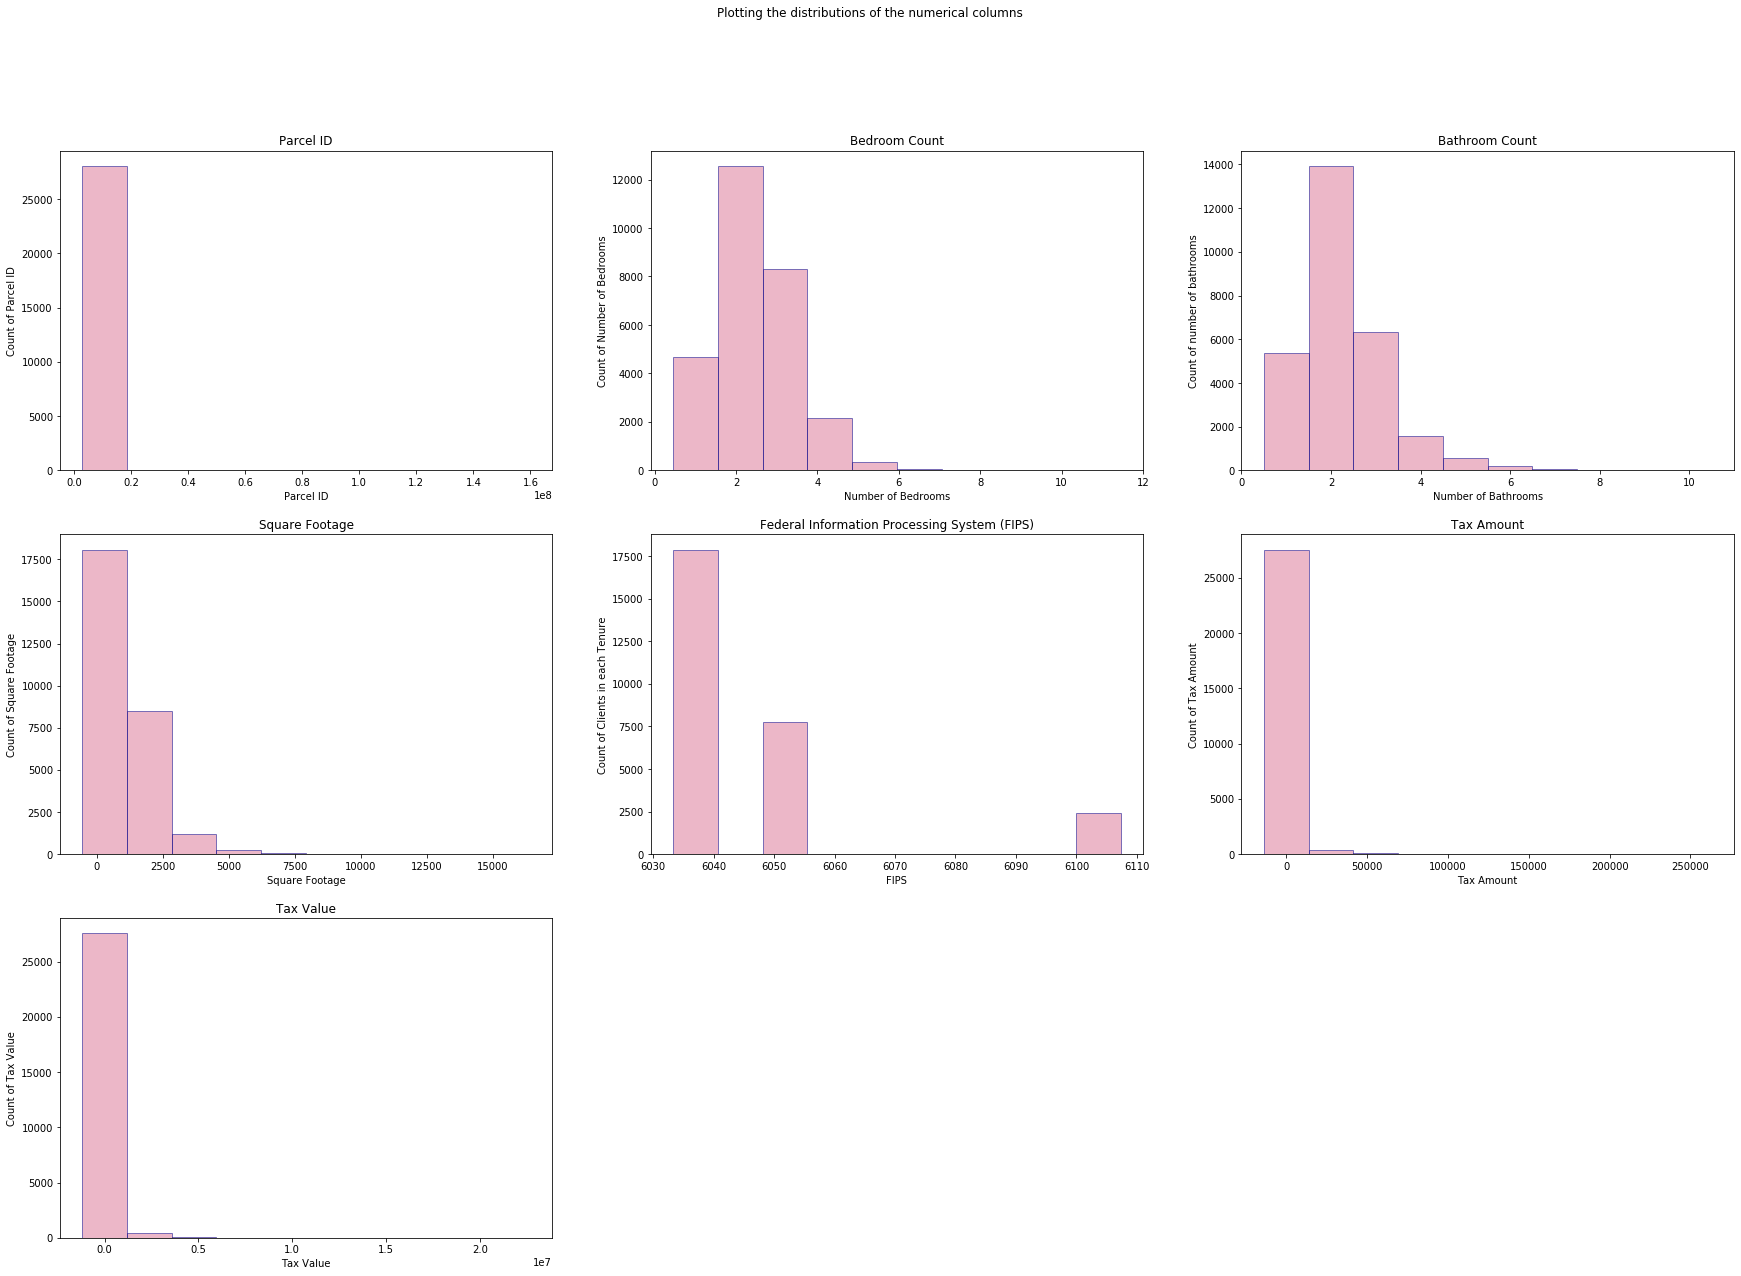

In [7]:
plt.figure(figsize=(30, 20))

plt.suptitle("Plotting the distributions of the numerical columns")
# row, columns, index
plt.subplot(3, 3, 1)
plt.hist(df.parcelid, align='left', edgecolor='darkblue', alpha=0.5, color='palevioletred')
plt.title('Parcel ID')
plt.xlabel("Parcel ID")
plt.ylabel("Count of Parcel ID")


plt.subplot(3, 3, 2)
plt.hist(df.bedroomcnt, align='left', edgecolor='darkblue', alpha=0.5, color='palevioletred')
plt.title('Bedroom Count')
plt.xlabel("Number of Bedrooms")
plt.ylabel("Count of Number of Bedrooms")


plt.subplot(3, 3, 3)
plt.hist(df.bathroomcnt, align='left', edgecolor='darkblue', alpha=0.5, color='palevioletred')
plt.title('Bathroom Count')
plt.xlabel("Number of Bathrooms")
plt.ylabel("Count of number of bathrooms")


plt.subplot(3, 3, 4)
plt.hist(df.calculatedfinishedsquarefeet, align='left', edgecolor='darkblue', alpha=0.5, color='palevioletred')
plt.title('Square Footage')
plt.xlabel("Square Footage")
plt.ylabel("Count of Square Footage")


plt.subplot(3, 3, 5)
plt.hist(df.fips, align='left', edgecolor='darkblue', alpha=0.5, color='palevioletred')
plt.title('Federal Information Processing System (FIPS)')
plt.xlabel("FIPS")
plt.ylabel("Count of Clients in each Tenure")


plt.subplot(3, 3, 6)
plt.hist(df.taxamount, align='left', edgecolor='darkblue', alpha=0.5, color='palevioletred')
plt.title('Tax Amount')
plt.xlabel("Tax Amount")
plt.ylabel("Count of Tax Amount")

plt.subplot(3,3,7)
plt.hist(df.taxvaluedollarcnt, align='left', edgecolor='darkblue', alpha=0.5, color='palevioletred')
plt.title('Tax Value')
plt.xlabel("Tax Value")
plt.ylabel("Count of Tax Value")

In the prepare.py created, the following functions are defined:
<ul>
    <li> clean_zillow- Takes in the full dataframe from acquire.py, handles nans, renames columns and appends necessary data.
    <li> prep_zillow_data- Takes in the clean zillow data and splits into train, validate, test.
    <li> prep_split_zillow_data- This function takes in the clean data, drops the tax amount for modeling purposes and then splits the data into X/Y Train, Validate/Test.
    <li> remove_outliers_zillow- This function takes in the cleaned zillow data and handles outliers as needed.

# Explore

In [8]:
df=prepare.clean_zillow()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28073 entries, 0 to 28072
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fips            28073 non-null  float64
 1   lot_size        28073 non-null  float64
 2   square_feet     28073 non-null  float64
 3   bedroom_count   28073 non-null  float64
 4   bathroom_count  28073 non-null  float64
 5   tax_amount      28073 non-null  float64
 6   tax_value       28073 non-null  float64
 7   county          28073 non-null  object 
dtypes: float64(7), object(1)
memory usage: 1.7+ MB


In [9]:
train, validate, test = prepare.prep_zillow_data()

## Hypothesis Testing:
### 1st Hypothesis Test:
$H_0$: Homes have the same mean tax value in each county.

$H_a$: Homes in Los Angeles have a higher mean tax value than in Ventura or Orange Counties.

alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [10]:
n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval
null_hypothesis = "homes have the same mean tax value in each county."

In [11]:
x1 = train[train.county == 'los_angeles_county'].tax_value
x2 = train[train.county != 'los_angeles_county'].tax_value

x_bar1 = x1.mean()
x_bar2 = x2.mean()

n1 = x1.shape[0]
n2 = x2.shape[0]

s1 = x1.std()
s2 = x2.std()

degf = n1 + n2 - 2

s_p = sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))


standard_error = se = sqrt(s1**2 / n1 + s2**2 / n2)

t= (x_bar1 - x_bar2)/ (s_p * sqrt(1/n1 + 1/n2))

In [12]:
p = stats.t(degf).sf(t) * 2
stats.ttest_ind(x1, x2)
print(f't = {t:.5f}')
print(f'p = {p:.5f}')
stats.ttest_ind(x1, x2)

t = -5.65890
p = 2.00000


Ttest_indResult(statistic=-5.65889745308946, pvalue=1.553889721671033e-08)

In [13]:
if p > α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
elif t < 0 :
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We fail to reject the null hypothesis. The null hypothesis is that homes have the same mean tax value in each county.


### 2nd Hypothesis Test:
𝐻0 : Number of bathrooms have no correlation with tax value.

𝐻𝑎 : Homes with more bathrooms are correlated with higher tax values.

alpha ( 𝛼 ): 1 - confidence level (95% confidence level ->  𝛼=.05 )

In [14]:
n = df.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval
null_hypothesis='number of bathrooms have no correlation with tax value.'

In [15]:
x = df.bathroom_count
y = df.tax_value

In [16]:
corr, p = stats.pearsonr(x, y)
corr, p

(0.52616664170778, 0.0)

In [17]:
if p >  α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
elif t < 0 :
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We fail to reject the null hypothesis. The null hypothesis is that number of bathrooms have no correlation with tax value.


### 3rd Hypothesis Test:
𝐻0 : Number of bedrooms have no correlation with tax value.

𝐻𝑎 : Homes with more bedrooms are correlated with higher tax values.

alpha ( 𝛼 ): 1 - confidence level (95% confidence level ->  𝛼=.05 )

In [18]:
n = df.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval
null_hypothesis='number of bedrooms have no correlation with tax value.'

In [19]:
x2 = df.bedroom_count
y2 = df.tax_value

In [20]:
corr, p = stats.pearsonr(x2, y2)
corr, p

(0.2807020979909201, 0.0)

In [21]:
if p >  α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
elif t < 0 :
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We fail to reject the null hypothesis. The null hypothesis is that number of bedrooms have no correlation with tax value.


### 4th Hypothesis Test:
𝐻0 : Square footage has no correlation with tax value.

𝐻𝑎 : Homes with a higher square footage are correlated with higher tax values.

alpha ( 𝛼 ): 1 - confidence level (95% confidence level ->  𝛼=.05 )

In [22]:
n = df.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval
null_hypothesis="square footage has no correlation with tax value."

In [23]:
x3 = df.square_feet
y3 = df.tax_value

In [24]:
corr, p = stats.pearsonr(x3, y3)
corr, p

(0.611763274652983, 0.0)

In [25]:
if p >  α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
elif t < 0 :
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We fail to reject the null hypothesis. The null hypothesis is that square footage has no correlation with tax value.


In [26]:
np.random.seed(1019)
train, validate, test = prepare.prep_zillow_data()
train.shape, validate.shape, test.shape

((13755, 8), (5896, 8), (8422, 8))

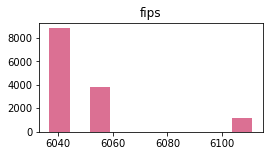

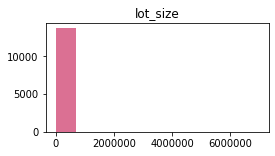

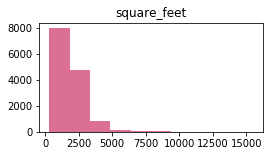

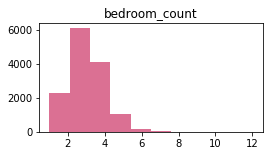

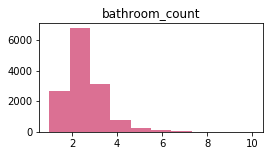

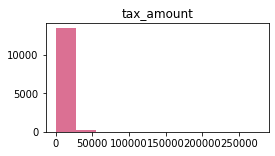

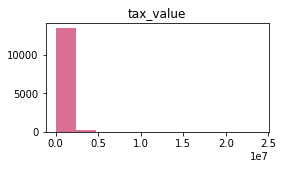

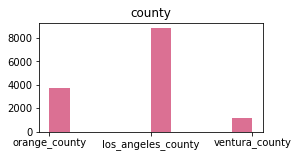

In [27]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col], color="palevioletred")
    plt.title(col)
    plt.show()

# Feature Engineering

# Model

In [28]:
X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.prep_split_zillow_data()

In [29]:
X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

((15720, 1), (6738, 1), (5615, 1), (15720, 1), (6738, 1), (5615, 1))

In [30]:
X_train.head()

,tax_value
16223,54624.0
428,638000.0
453,89105.0
27470,219000.0
13093,779236.0


In [31]:
y_train.head()

,tax_value
16223,54624.0
428,638000.0
453,89105.0
27470,219000.0
13093,779236.0


In [32]:
train.tax_value.describe().apply(lambda x: format(x, 'f'))

count       13755.000000
mean       535930.102508
std        725279.581789
min         13199.000000
25%        199178.500000
50%        384198.000000
75%        635084.500000
max      23858374.000000
Name: tax_value, dtype: object

#### Baseline

In [33]:
baseline = train.tax_value.mean()

baseline_mse = mean_squared_error(y_train, np.full(y_train.shape, baseline))
baseline_rmse = baseline_mse**1/2

print('The Baseline Mean Squared Error:', round(baseline_mse,2))
print('The Baseline Root Mean Squared Error:', round(baseline_rmse,2))

The Baseline Mean Squared Error: 483539975715.93
The Baseline Root Mean Squared Error: 241769987857.96


#### Linear Regression Model

In [34]:
# create the object
lm = LinearRegression(normalize=True)

# fit object to the train data only
lm.fit(X_train, y_train)

# Predict our training observations
lm_pred = lm.predict(X_train)

# evaluate the training predictions
# compute root mean squared error
lm_mse = mean_squared_error(y_train, lm_pred)
lm_rmse = lm_mse**1/2

lm_rmse

5.154348544027519e-20

#### Lasso Lars Model

In [35]:
# create the object
lars = LassoLars(alpha=0.1)

# fit to the train data only
lars.fit(X_train, y_train)

# predict our training observations
lars_pred = lars.predict(X_train)

# evaluate our training predictions
lars_mse = mean_squared_error(y_train, lars_pred)
lars_rmse = lars_mse**1/2

lars_rmse

78.59999999391218

#### Polynomial Model

In [36]:
pf = PolynomialFeatures(degree=3)

# fit and transform the thing
# to get a new set of features..which are the original features sqauared
X_train_cubed = pf.fit_transform(X_train)

# fit the model using our training observations that have been cubed.
# feed that data into our linear model
# make the thing
lm_cubed = LinearRegression()
lm_cubed.fit(X_train_cubed, y_train)

# predict our training observations (the cubed version)
lm_cubed_pred = lm_cubed.predict(X_train_cubed)

# evaluate our predictions on training observations
lm_cubed_mse = mean_squared_error(y_train, lm_cubed_pred)
lm_cubed_rmse = lm_cubed_mse**1/2

lm_cubed_rmse

284623714.2972265

#### Tweedie Regressor (GLM) Model

In [39]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['tv_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_glm)**1/2

# predict validate
y_validate['tv_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_glm)**1/2

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  241760961284.40634 
Validation/Out-of-Sample:  292299392470.37885


# Conclusion and Recommendations